In [2]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
points = (np.array([-1, 0, 1]), np.array([-1, 0, 1]))

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [750]:
from wimpy.analysis import extended_loglikelihood

def arrays_to_grid(arrs):
    return np.stack(np.meshgrid(*arrs), axis=-1)   

class DependentUncertaintyMixer():
    anchor_z_grid = None     # numpy array containing z-parameters of each anchor model
    anchor_models = None     # dictionary mapping z-parameters to actual anchor models
    
    def __init__(self, anchor_models, anchor_z_arrays):
        self.anchor_models = anchor_models
        self.anchor_z_arrays = anchor_z_arrays
        self.anchor_z_grid = arrays_to_grid(anchor_z_arrays)
        
        self.n_sources = len(list(self.anchor_models.values())[0].expected_events())
        self.mu_maker = self.make_interpolator(f=lambda m: m.expected_events(), extra_dims=[self.n_sources])
        
    def loglikelihood(self, *zs):
        """Return the loglikelihood of the data (previously set with set_data) at the given z-values.
        """
        # The interpolators want numpy arrays: give it to them...
        zs = np.asarray([zs])
        # The interpolators return numpy arrays with one extra dimension: remove it...
        result =  extended_loglikelihood(mu=self.mu_maker(zs)[0],
                                         ps=self.ps_maker(zs)[0])
        # Add the penalties for the z-values
        result += stats.norm(0,1).logpdf(zs).sum()
        return result
        
    def set_data(self, d):
        self.ps_maker =  self.make_interpolator(f=lambda m: m.score_events(d), 
                                                extra_dims=[self.n_sources, len(d)])
    
    def make_interpolator(self, f, extra_dims):
        """Return an interpolator which interpolates the extra_dims-valued function f(model) 
        between the anchor points
        """
        anchor_scores = np.zeros(list(self.anchor_z_grid.shape)[:-1] + extra_dims)
        fake_grid = np.zeros(list(self.anchor_z_grid.shape)[:-1])   # Only used for iteration...
        it = np.nditer(fake_grid, flags=['multi_index'])
#         print(anchor_scores.shape, fake_grid.shape)
#         print(list(it.multi_index) + [slice(None)] * len(extra_dims))
        while not it.finished:
            zs = tuple(self.anchor_z_grid[list(it.multi_index) + [slice(None)]])
            anchor_scores[list(it.multi_index) + [slice(None)] * len(extra_dims)] = f(self.anchor_models[zs])
            it.iternext()
#         print(self.anchor_z_arrays, anchor_scores.shape)
        return RegularGridInterpolator(self.anchor_z_arrays, anchor_scores)


In [751]:
class FakeModel(object):
    p = 1
    mu = 1
    n_sources = 4
    
    def __init__(self, config=None, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def expected_events(self):
        return [self.mu] * self.n_sources
        
    def score_events(self, d):
        return np.ones((self.n_sources, len(d))) * self.p
    

# Try one uncertainty

In [752]:
anchor_z_arrays = (np.array([-5, -1, 0, 1, 5]),)
grid = arrays_to_grid(anchor_z_arrays)
anchor_models = {tuple(z): FakeModel(p=1/(1 + abs(z[0])))
                 for z in grid.reshape(-1, len(anchor_z_arrays))}

In [753]:
dum = DependentUncertaintyMixer(anchor_models, anchor_z_arrays)

In [754]:
d = np.zeros(10)
dum.set_data(d)

In [755]:
dum.mu_maker(np.array([0,]))[0].shape

(4,)

In [756]:
dum.ps_maker(np.array([0,]))[0].shape

(4, 10)

In [757]:
dum.anchor_models

{(-5,): <__main__.FakeModel at 0x7fb47da432e8>,
 (-1,): <__main__.FakeModel at 0x7fb47da430b8>,
 (0,): <__main__.FakeModel at 0x7fb47da431d0>,
 (1,): <__main__.FakeModel at 0x7fb47da43240>,
 (5,): <__main__.FakeModel at 0x7fb47da430f0>}

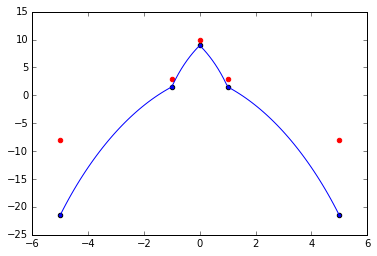

In [758]:
x = np.linspace(-5, 5, 100)
y = np.array([dum.loglikelihood(q) for q in x])
plt.plot(x, y)


zs = []
results = []
results_nopenalty = []
for (z,), m in dum.anchor_models.items():
    zs.append(z)
    result = extended_loglikelihood(mu=np.array(m.expected_events()), 
                                    ps=m.score_events(d))
    results_nopenalty.append(result)
    result += stats.norm(0,1).logpdf(z)
    results.append(result)
    
plt.scatter(zs, results)
plt.scatter(zs, results_nopenalty, color='red')
    
# plt.plot(x, 1/(1+np.abs(x)) + stats.norm.logpdf(x))

# Try 2 uncertainties

In [759]:
anchor_z_arrays = (np.array([-1, 0, 1]), np.array([-2, 0, 2]))
grid = arrays_to_grid(anchor_z_arrays)
anchor_models = {tuple(z): FakeModel(p=1/(1 + abs(z[0] + z[1])))
                 for z in grid.reshape(-1, len(anchor_z_arrays))}

In [760]:
dum = DependentUncertaintyMixer(anchor_models, anchor_z_arrays)

In [761]:
d = np.zeros(10)
dum.set_data(d)

In [762]:
dum.mu_maker(np.array([0, 0]))[0].shape

(4,)

In [763]:
dum.ps_maker(np.array([0, 0]))[0].shape

(4, 10)

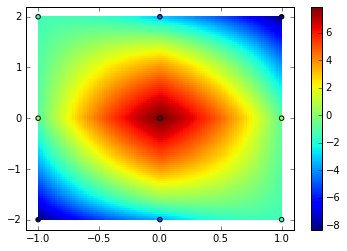

In [764]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-2, 2, 100)

pointpairs = arrays_to_grid((x, y)).reshape(-1, 2)
z = np.zeros(len(pointpairs))
for i, p in enumerate(tqdm(pointpairs)):
    z[i] = dum.loglikelihood(*p)
z = z.reshape(len(x), len(y))

plt.pcolormesh(x, y, z.T)
plt.colorbar()
plt.xlim(1.1 * x.min(), 1.1 * x.max())
plt.ylim(1.1 * y.min(), 1.1 * y.max())

xs = []
ys = []
zs = []
for (x, y), m in dum.anchor_models.items():
    xs.append(x)
    ys.append(y)
    result = extended_loglikelihood(mu=np.array(m.expected_events()), 
                                     ps=m.score_events(d))
    result += stats.norm(0,1).logpdf([x, y]).sum()
    zs.append(result)
    
plt.scatter(xs, ys, c=zs, s=20)


Why interpolate the mus and individual event ps instead of just the final loglikelihood fo the entire dataset? In the latter case you could never do better than the lowest anchor point.